In [1]:
%cd /content
!git clone https://github.com/MioAyanokouji/FunSearch-TSP.git
%cd /content/FunSearch-TSP

/content
Cloning into 'FunSearch-TSP'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 203 (delta 25), reused 179 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.15 MiB | 5.66 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/FunSearch-TSP


## 1-DataSet

In [2]:
!pip install tsplib95

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
bigframes 2.1.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cubla

In [3]:
import tsplib95
import pandas as pd
import matplotlib.pyplot as plt

import glob, os

import numpy as np
from itertools import chain
from scipy.spatial.distance import squareform, pdist
from functools import partial
import math

from typing import List

import random

In [4]:
# edge_weight_type = []
# edge_weight_format = []

# for file in glob.glob("./data/*.tsp"):
#     problem = tsplib95.load(file)
#     if problem.edge_weight_type == 'EXPLICIT':
#         edge_weight_format.append(problem.edge_weight_format)
#     else:
#         edge_weight_type.append(problem.edge_weight_type)

# edge_weight_type = list(set(edge_weight_type))
# edge_weight_format = list(set(edge_weight_format))

# print(edge_weight_type)
# print(edge_weight_format)

In [5]:
class TSPProblem:
    def __init__(self, problem_path=None):
        problem = tsplib95.load(problem_path)
        self.name = problem.name
        self.dimension = problem.dimension

        if problem.edge_weight_type == 'EXPLICIT':
            # nodes
            self.nodes = pd.DataFrame.from_dict(problem.display_data, orient='index', columns=['x', 'y'])

            # distance matrix
            if problem.edge_weight_format == 'FULL_MATRIX':
                self.distance_matrix = problem.edge_weights
            else:
                if problem.edge_weight_format == 'LOWER_DIAG_ROW':
                    idx = np.tril_indices(self.dimension)
                if problem.edge_weight_format == 'UPPER_ROW':
                    idx = np.triu_indices(self.dimension, k=1)
                if problem.edge_weight_format == 'UPPER_DIAG_ROW':
                    idx = np.triu_indices(self.dimension)

                distance = list(chain(*problem.edge_weights))
                self.distance_matrix = np.zeros((self.dimension, self.dimension))
                self.distance_matrix[idx] = distance
                self.distance_matrix[idx[1], idx[0]] = distance
        else:
            # nodes
            self.nodes = pd.DataFrame.from_dict(problem.node_coords, orient='index', columns=['x', 'y'])

            # distance matrix
            if problem.edge_weight_type == 'EUC_2D':
                self.distance_matrix = squareform(pdist(self.nodes, tsplib95.distances.euclidean))
            if problem.edge_weight_type == 'CEIL_2D':
                self.distance_matrix = squareform(pdist(self.nodes, partial(tsplib95.distances.euclidean, round=math.ceil)))
            if problem.edge_weight_type == 'GEO':
                self.distance_matrix = squareform(pdist(self.nodes, tsplib95.distances.geographical))
            if problem.edge_weight_type == 'ATT':
                self.distance_matrix = squareform(pdist(self.nodes, tsplib95.distances.pseudo_euclidean))

        self.distance_matrix = pd.DataFrame(self.distance_matrix, index=range(1, self.dimension+1), columns=range(1, self.dimension+1))

        # opt
        opt_path = os.path.splitext(problem_path)[0] + '.opt.tour'
        if os.path.isfile(opt_path):
            opt = tsplib95.load(opt_path)
            self.optimal_tour = opt.tours[0]
        else:
            self.optimal_tour = None

    def get_tour_length(self, tour: List[int]) -> float:
        length = 0
        for i in range(len(tour)):
            length += self.distance_matrix[tour[i]][tour[(i+1)%len(tour)]]
        return length

    def plot_tour(self, tour: List[int]):
        plt.figure(figsize=(10, 6))

        # nodes
        x = self.nodes.x
        y = self.nodes.y
        plt.scatter(x, y, color='#E53528', zorder=2)

        # annotation
        for i in range(self.dimension):
            plt.annotate(str(i+1), (x[i+1], y[i+1]), fontsize=6, xytext=(2, 2), textcoords='offset points')

        # tour
        for i in range(len(tour)):
            start = tour[i]
            end = tour[(i+1)%len(tour)]
            plt.plot([x[start], x[end]], [y[start], y[end]], color='#55B7E6', zorder=1)

        plt.title(f'{self.name} - Length: {self.get_tour_length(tour):.2f}')
        plt.show()

In [6]:
a280 = TSPProblem('./data/a280.tsp')

In [7]:
a280.nodes.head()

,x,y
1,288,149
2,288,129
3,270,133
4,256,141
5,256,157


In [8]:
a280.distance_matrix

,1,2,3,4,5,6,7,8,9,10,...,271,272,273,274,275,276,277,278,279,280
1,0.0,20.0,24.0,33.0,33.0,43.0,56.0,63.0,61.0,71.0,...,92.0,84.0,76.0,68.0,60.0,52.0,43.0,43.0,34.0,18.0
2,20.0,0.0,18.0,34.0,43.0,50.0,66.0,72.0,68.0,79.0,...,93.0,86.0,78.0,70.0,62.0,54.0,44.0,36.0,28.0,9.0
3,24.0,18.0,0.0,16.0,28.0,34.0,50.0,55.0,50.0,62.0,...,75.0,67.0,59.0,51.0,44.0,36.0,25.0,20.0,11.0,10.0
4,33.0,34.0,16.0,0.0,16.0,19.0,34.0,40.0,34.0,46.0,...,60.0,52.0,44.0,36.0,28.0,20.0,10.0,16.0,13.0,25.0
5,33.0,43.0,28.0,16.0,0.0,10.0,23.0,30.0,28.0,38.0,...,61.0,53.0,46.0,38.0,30.0,23.0,19.0,32.0,28.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,52.0,54.0,36.0,20.0,23.0,16.0,24.0,25.0,18.0,29.0,...,40.0,32.0,24.0,16.0,8.0,0.0,11.0,26.0,29.0,46.0
277,43.0,44.0,25.0,10.0,19.0,16.0,30.0,33.0,27.0,38.0,...,50.0,42.0,34.0,26.0,18.0,11.0,0.0,17.0,18.0,35.0
278,43.0,36.0,20.0,16.0,32.0,33.0,47.0,50.0,43.0,54.0,...,59.0,52.0,45.0,38.0,31.0,26.0,17.0,0.0,9.0,29.0
279,34.0,28.0,11.0,13.0,28.0,31.0,47.0,51.0,45.0,57.0,...,66.0,58.0,51.0,43.0,36.0,29.0,18.0,9.0,0.0,20.0


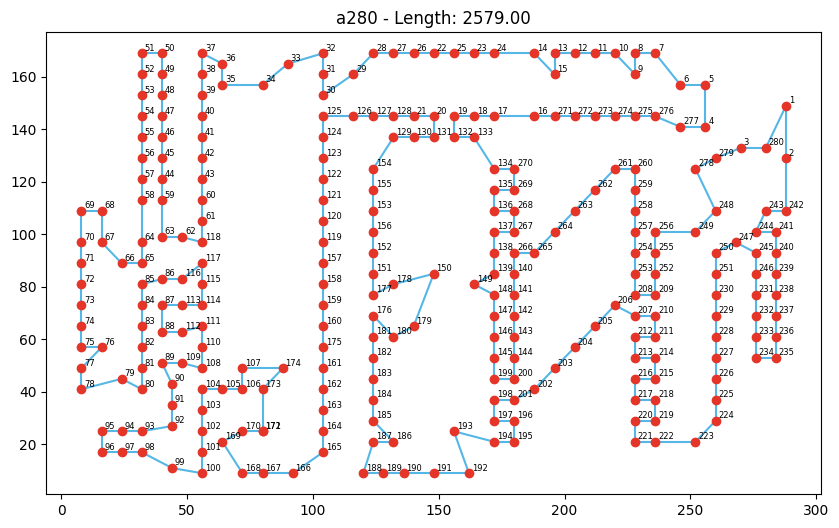

In [9]:
a280.plot_tour(a280.optimal_tour)

In [10]:
# random.seed(0)
# dataset_path = random.sample(glob.glob("./data/*.tsp"), k=5)

dataset_path = ['./data/a280.tsp', './data/att48.tsp', './data/bayg29.tsp', './data/bays29.tsp', './data/berlin52.tsp']

dataset = {}
for path in dataset_path:
    problem = TSPProblem(path)
    dataset[problem.name] = problem.distance_matrix.to_numpy()

## 2-LLM

In [11]:
# !pip install absl-py

In [12]:
import time
import json
import multiprocessing
from typing import Collection, Any
import http.client
from implementation import sampler

In [13]:
api_key = 'sk-0ivLxCmk7HNR86iH81Aa4dC92aA34439AbE5F857BeC1F433'

In [14]:
def _trim_preface_of_body(sample: str) -> str:
    """Trim the redundant descriptions/symbols/'def' declaration before the function body.
    Please see my comments in sampler.LLM (in sampler.py).
    Since the LLM used in this file is not a pure code completion LLM, this trim function is required.

    -Example sample (function & description generated by LLM):
    -------------------------------------
    This is the optimized function ...
    def priority_v2(...) -> ...:
        return ...
    This function aims to ...
    -------------------------------------
    -This function removes the description above the function's signature, and the function's signature.
    -The indent of the code is preserved.
    -Return of this function:
    -------------------------------------
        return ...
    This function aims to ...
    -------------------------------------
    """
    lines = sample.splitlines()
    func_body_lineno = 0
    find_def_declaration = False
    for lineno, line in enumerate(lines):
        # find the first 'def' statement in the given code
        if line[:3] == 'def':
            func_body_lineno = lineno
            find_def_declaration = True
            break
    if find_def_declaration:
        code = ''
        for line in lines[func_body_lineno + 1:]:
            code += line + '\n'
        return code
    return sample

class LLMAPI(sampler.LLM):
    """Language model that predicts continuation of provided source code.
    """

    def __init__(self, samples_per_prompt: int, trim=True):
        super().__init__(samples_per_prompt)
        additional_prompt = ('Complete a different and more complex Python function.'
                             'Be creative and you can insert multiple if-else and for-loop in the code logic.'
                             'Only output the Python code, no descriptions.')
        self._additional_prompt = additional_prompt
        self._trim = trim

    def draw_samples(self, prompt: str) -> Collection[str]:
        """Returns multiple predicted continuations of `prompt`."""
        return [self._draw_sample(prompt) for _ in range(self._samples_per_prompt)]

    def _draw_sample(self, content: str) -> str:
        prompt = '\n'.join([content, self._additional_prompt])
        while True:
            try:
                conn = http.client.HTTPSConnection("api.bltcy.ai")
                payload = json.dumps({
                    "max_tokens": 512,
                    "model": "gpt-3.5-turbo",
                    "messages": [
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ]
                })
                headers = {
                    'Authorization': f'Bearer {api_key}',
                    'User-Agent': 'Apifox/1.0.0 (https://apifox.com)',
                    'Content-Type': 'application/json'
                }
                conn.request("POST", "/v1/chat/completions", payload, headers)
                res = conn.getresponse()
                data = res.read().decode("utf-8")
                data = json.loads(data)
                response = data['choices'][0]['message']['content']
                # trim function
                if self._trim:
                    response = _trim_preface_of_body(response)
                return response
            except Exception:
                time.sleep(2)
                continue

## 3-SandBox

In [15]:
from implementation import evaluator
from implementation import evaluator_accelerate

In [16]:
class Sandbox(evaluator.Sandbox):
    """Sandbox for executing generated code. Implemented by RZ.

    RZ: Sandbox returns the 'score' of the program and:
    1) avoids the generated code to be harmful (accessing the internet, take up too much RAM).
    2) stops the execution of the code in time (avoid endless loop).
    """

    def __init__(self, verbose=False, numba_accelerate=True):
        """
        Args:
            verbose         : Print evaluate information.
            numba_accelerate: Use numba to accelerate the evaluation. It should be noted that not all numpy functions
                              support numba acceleration, such as np.piecewise().
        """
        self._verbose = verbose
        self._numba_accelerate = numba_accelerate

    def run(
            self,
            program: str,
            function_to_run: str,  # RZ: refers to the name of the function to run (e.g., 'evaluate')
            function_to_evolve: str,  # RZ: accelerate the code by decorating @numba.jit() on function_to_evolve.
            inputs: Any,  # refers to the dataset
            test_input: str,  # refers to the current instance
            timeout_seconds: int,
            **kwargs  # RZ: add this
    ) -> tuple[Any, bool]:
        """Returns `function_to_run(test_input)` and whether execution succeeded.

        RZ: If the generated code (generated by LLM) is executed successfully,
        the output of this function is the score of a given program.
        RZ: PLEASE NOTE THAT this SandBox is only designed for bin-packing problem.
        """
        dataset = inputs[test_input]
        try:
            result_queue = multiprocessing.Queue()
            process = multiprocessing.Process(
                target=self._compile_and_run_function,
                args=(program, function_to_run, function_to_evolve, dataset, self._numba_accelerate, result_queue)
            )
            process.start()
            process.join(timeout=timeout_seconds)
            if process.is_alive():
                # if the process is not finished in time, we consider the program illegal
                process.terminate()
                process.join()
                results = None, False
            else:
                if not result_queue.empty():
                    results = result_queue.get_nowait()
                else:
                    results = None, False

            return results
        except:
            return None, False

    def _compile_and_run_function(self, program, function_to_run, function_to_evolve, dataset, numba_accelerate,
                                  result_queue):
        try:
            # optimize the code (decorate function_to_run with @numba.jit())
            if numba_accelerate:
                program = evaluator_accelerate.add_numba_decorator(
                    program=program,
                    function_to_evolve=function_to_evolve
                )
            # compile the program, and maps the global func/var/class name to its address
            all_globals_namespace = {}
            # execute the program, map func/var/class to global namespace
            exec(program, all_globals_namespace)
            # get the pointer of 'function_to_run'
            function_to_run = all_globals_namespace[function_to_run]
            # return the execution results
            results = function_to_run(dataset)
            # the results must be int or float
            if not isinstance(results, (int, float)):
                result_queue.put((None, False))
                return
            result_queue.put((results, True))
        except Exception:
            # if raise any exception, we assume the execution failed
            result_queue.put((None, False))

## 4-Specification

In [17]:
import numpy as np

def tsp(distance_matrix):
    """Solves the Traveling Salesman Problem (TSP) using a greedy nearest-neighbor heuristic."""
    num_nodes = len(distance_matrix)
    start_node = 0
    tour = [start_node]
    visited = np.full(num_nodes, False, dtype=bool)
    visited[start_node] = True
    total_distance = 0

    while(len(tour) < num_nodes):
        priorities = np.ma.array(priority(distance_matrix, tour), mask=visited)

        next_node = int(np.ma.argmax(priorities))
        total_distance += distance_matrix[tour[-1]][next_node]
        tour.append(next_node)
        visited[next_node] = True

    total_distance += distance_matrix[tour[-1]][start_node]
    tour = [node + 1 for node in tour]
    return tour, total_distance

# @funsearch.run
def evaluate(distance_matrix):
    """Evaluate heuristic function on a set of distance matrix instances."""
    tour, total_distance = tsp(distance_matrix)
    return -total_distance

# @funsearch.evolve
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    return priorities

In [18]:
tour, total_distance = tsp(a280.distance_matrix.to_numpy())
total_distance

np.float64(3157.0)

In [19]:
specification = r'''
import numpy as np

def tsp(distance_matrix):
    """Solves the Traveling Salesman Problem (TSP) using a greedy nearest-neighbor heuristic."""
    num_nodes = len(distance_matrix)
    start_node = 0
    tour = [start_node]
    visited = np.full(num_nodes, False, dtype=bool)
    visited[start_node] = True
    total_distance = 0

    while(len(tour) < num_nodes):
        priorities = np.ma.array(priority(distance_matrix, tour), mask=visited)

        next_node = int(np.ma.argmax(priorities))
        total_distance += distance_matrix[tour[-1]][next_node]
        tour.append(next_node)
        visited[next_node] = True

    total_distance += distance_matrix[tour[-1]][start_node]
    tour = [node + 1 for node in tour]
    return tour, total_distance

@funsearch.run
def evaluate(distance_matrix):
    """Evaluate heuristic function on a set of distance matrix instances."""
    tour, total_distance = tsp(distance_matrix)
    return -total_distance

@funsearch.evolve
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    return priorities
'''

## 5-Main

In [20]:
# !pip install torch
# !pip install tensorboard

In [21]:
from implementation import funsearch
from implementation import config

In [22]:
# It should be noted that the if __name__ == '__main__' is required.
# Because the inner code uses multiprocess evaluation.
if __name__ == '__main__':
    class_config = config.ClassConfig(llm_class=LLMAPI, sandbox_class=Sandbox)
    main_config = config.Config(samples_per_prompt=4, evaluate_timeout_seconds=30)
    global_max_sample_num = 500  # if it is set to None, funsearch will execute an endless loop
    funsearch.main(
        specification=specification,
        inputs=dataset,
        config=main_config,
        max_sample_nums=global_max_sample_num,
        class_config=class_config,
        log_dir='../logs/funsearch_llm_api'
    )

INFO:absl:Best score of island 0 increased to -6750.75
INFO:absl:Best score of island 1 increased to -6750.75
INFO:absl:Best score of island 2 increased to -6750.75
INFO:absl:Best score of island 3 increased to -6750.75
INFO:absl:Best score of island 4 increased to -6750.75
INFO:absl:Best score of island 5 increased to -6750.75
INFO:absl:Best score of island 6 increased to -6750.75
INFO:absl:Best score of island 7 increased to -6750.75
INFO:absl:Best score of island 8 increased to -6750.75
INFO:absl:Best score of island 9 increased to -6750.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    return priorities
----------------------------------------------

INFO:absl:Best score of island 6 increased to 0.0


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for i in range(num_nodes):
        if i not in tour:
            distance_sum = 0
            count = 0
            for node in tour:
                if node != current_node:
     

INFO:absl:Best score of island 8 increased to -6615.5


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            distance_to_node = distance_matrix[current_node][node]
            num_unvisited_adjacent = 0
            for

INFO:absl:Best score of island 1 increased to -6228.25


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)
    
    for node in range(num_nodes):
        if node not in tour:
            if len(tour) < num_nodes - 1:
                min_distance = min(distance_matrix[node])
                m

INFO:absl:Best score of island 5 increased to -6749.25


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            tour_length = len(tour)
            total_distance = 0
            for i in range(tour_length - 1):
         

INFO:absl:Best score of island 3 increased to -6749.25


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            total_distance = 0
            for i in range(len(tour)-1):
                total_distance += distance_matrix

INFO:absl:Best score of island 0 increased to -6749.5


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)
    
    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')
        
        elif len(tour) < 2:
            priorities[node] = -distanc

INFO:absl:Best score of island 3 increased to -6737.5


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            total_distance = 0
            for i in range(len(tour)-1):
                total_distance += distance_matrix

INFO:absl:Best score of island 4 increased to -6737.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            dist = distance_matrix[current_node][node]
            priority = -dist
            if dist > 10:
           

INFO:absl:Best score of island 8 increased to -6212.25


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            distance_to_node = distance_matrix[current_node][node]
            num_unvisited_adjacent = 0
            for

INFO:absl:Best score of island 3 increased to -6730.5


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            total_distance = 0
            for i in range(len(tour)-1):
                total_distance += distance_matrix

INFO:absl:Best score of island 2 increased to -6735.0


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    for node in range(num_nodes):
        if node not in tour:
     

INFO:absl:Best score of island 8 increased to -6189.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            distance_to_node = distance_matrix[current_node][node]
            num_unvisited_adjacent = 0
            for

INFO:absl:Best score of island 4 increased to -6730.0


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            dist = distance_matrix[current_node][node]
            priority = -dist
            if dist > 10:
           

INFO:absl:Best score of island 4 increased to -6729.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            dist = distance_matrix[current_node][node]
            priority = -dist
            if dist > 10:
           

INFO:absl:Best score of island 9 increased to -6748.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')
        else:
            total_distance = 0
            for i in ran

INFO:absl:Best score of island 9 increased to -6734.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')
        else:
            total_distance = 0
            for i in ran

INFO:absl:Best score of island 7 increased to 0.0


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    visited_nodes = set(tour)

    min_distance = float('inf')
    for i in range(num_nodes):
        if i not in visited_nodes:
            if distance_matrix[current_node]

INFO:absl:Best score of island 9 increased to -6713.25


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    """Improved version of `priority_v1`."""
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')
        else:
          

INFO:absl:Best score of island 8 increased to -6143.5


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            distance_to_node = distance_matrix[current_node][node]
            num_unvisited_adjacent = 0
            for

INFO:absl:Best score of island 2 increased to -6733.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    for node in range(num_nodes):
        if node not in tour:
     

INFO:absl:Best score of island 2 increased to -6724.75


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    for node in range(num_nodes):
        if node not in tour:
     

INFO:absl:Best score of island 8 increased to -6117.5


================= Evaluated Function =================
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = np.zeros(num_nodes)

    for node in range(num_nodes):
        if node not in tour:
            distance_to_node = distance_matrix[current_node][node]
            num_unvisited_adjacent = 0
            for